# Exploring Dandiset 001375: Septum GABA disruption with DREADDs

**Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results, and verify findings independently.

## Overview

This dandiset contains electrophysiological recordings from mice investigating the effects of septal GABAergic disruption on hippocampal and neocortical activity. The experiment used DREADDs (Designer Receptors Exclusively Activated by Designer Drugs) to suppress GABA interneurons in the medial septum while recording neural activity during a virtual hallway navigation task.

**Dandiset Link:** https://dandiarchive.org/dandiset/001375/0.250406.1855

## Required Packages

The following packages are required to run this notebook:
- `dandi`
- `pynwb` 
- `h5py`
- `remfile`
- `matplotlib`
- `numpy`
- `pandas`

In [1]:
import pynwb
import h5py
import remfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dandi.dandiapi import DandiAPIClient

## Exploring the Dandiset with DANDI API

In [2]:
# Access dandiset metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("001375", "0.250406.1855")
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

Dandiset name: Septum GABA disruption with DREADDs
Dandiset URL: https://dandiarchive.org/dandiset/001375/0.250406.1855


## NWB Files in the Dandiset

In [3]:
# List all NWB files and their sizes
assets = list(dandiset.get_assets_by_glob("*.nwb"))

print(f"Number of NWB files: {len(assets)}\n")
for asset in assets:
    sz = asset.size / (1024 ** 3)  # Convert to GB
    print(f"- {asset.path} ({sz:.2f} GB)")

Number of NWB files: 3

- sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb (51.20 GB)
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb (64.68 GB)
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb (65.00 GB)


The dandiset contains 3 large NWB files, each representing electrophysiological recordings from different experimental sessions. Each file can also be explored interactively using Neurosift:

- [sub-MS13B session](https://neurosift.app/nwb?dandisetId=001375&dandisetVersion=0.250406.1855&path=sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb)
- [sub-MS14A session (12781w8)](https://neurosift.app/nwb?dandisetId=001375&dandisetVersion=0.250406.1855&path=sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb)
- [sub-MS14A session (ardad2)](https://neurosift.app/nwb?dandisetId=001375&dandisetVersion=0.250406.1855&path=sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb)

## Loading and Exploring NWB Data

We'll examine the first NWB file to understand the data structure and content. The file is streamed remotely without downloading.

In [4]:
# Load the first NWB file via remote streaming
asset = next(dandiset.get_assets_by_glob("sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb"))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

## Session and Subject Information

In [5]:
# Extract basic session and subject metadata
info = {
    "Session description": nwb.session_description,
    "Session start time": str(nwb.session_start_time),
    "Subject ID": nwb.subject.subject_id,
    "Subject sex": nwb.subject.sex,
    "Subject species": nwb.subject.species,
    "Subject age": nwb.subject.age,
    "Subject description": nwb.subject.description,
}

# Get data structure information
n_electrodes = nwb.electrodes.to_dataframe().shape[0]
n_units = nwb.units.to_dataframe().shape[0]
n_trials = nwb.trials.to_dataframe().shape[0]

info["Number of electrodes"] = n_electrodes
info["Number of units"] = n_units
info["Number of trials"] = n_trials

print("Session and Subject Info:")
for k, v in info.items():
    print(f"{k}: {v}")

Session and Subject Info:
Session description: mouse running laps in virtual hallway
Session start time: 2024-07-25 19:00:00-07:00
Subject ID: MS13B
Subject sex: M
Subject species: Mus musculus
Subject age: P90D
Subject description: medial septum DREADD to suppress GABA interneurons
Number of electrodes: 256
Number of units: 33
Number of trials: 387


## Data Structure Overview

In [6]:
# Preview trial and unit data structures
trials_df = nwb.trials.to_dataframe().head()
units_df = nwb.units.to_dataframe().head()

print("First 5 trials:")
print(trials_df)
print("\nFirst 5 units (spike times truncated for display):")
print(units_df)

First 5 trials:
    start_time  stop_time
id                       
0     4.323800  16.929833
1    16.963067  28.414333
2    28.447100  39.402833
3    39.435833  50.027033
4    50.059667  63.064467

First 5 units (spike times truncated for display):
                                          spike_times
id                                                   
1   [3.5485, 3.5543666666666667, 3.784666666666667...
2   [0.1826, 0.21976666666666667, 0.77823333333333...
3   [0.005533333333333334, 0.01633333333333333, 0....
4   [0.5452333333333333, 0.5632, 0.572833333333333...
5   [0.07036666666666666, 0.1002, 0.17066666666666...


## Summary Statistics and Distributions

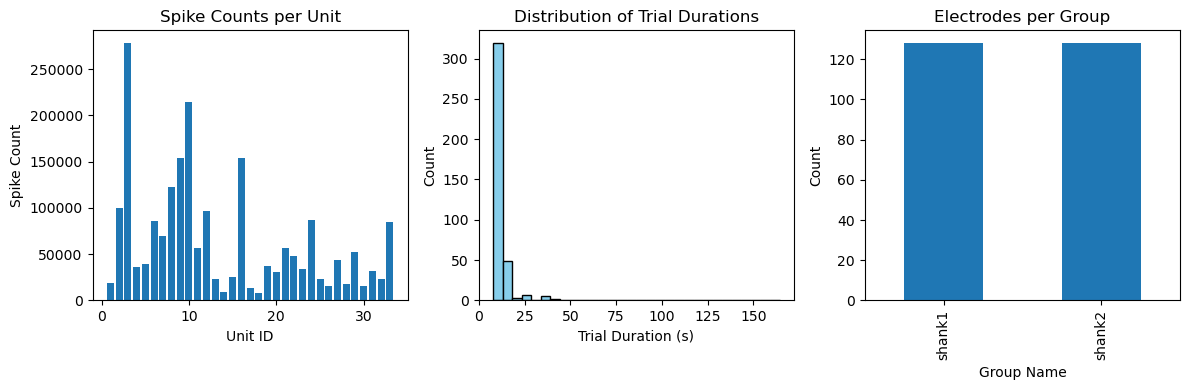

In [7]:
# Calculate summary statistics
units_df_full = nwb.units.to_dataframe()
trials_df_full = nwb.trials.to_dataframe()

# Distribution of spike counts per unit
spike_counts = units_df_full.spike_times.apply(len)

# Distribution of trial durations
trial_durations = trials_df_full['stop_time'] - trials_df_full['start_time']

# Create summary plots
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.bar(spike_counts.index, spike_counts.values)
plt.xlabel('Unit ID')
plt.ylabel('Spike Count')
plt.title('Spike Counts per Unit')

plt.subplot(1,3,2)
plt.hist(trial_durations, bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Count')
plt.title('Distribution of Trial Durations')

# Electrode group distribution
electrodes_df = nwb.electrodes.to_dataframe()
group_counts = electrodes_df['group_name'].value_counts()

plt.subplot(1,3,3)
group_counts.plot(kind='bar')
plt.title('Electrodes per Group')
plt.xlabel('Group Name')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Electrode Information

In [8]:
# Display electrode metadata sample
print("Sample electrode information:")
print(electrodes_df.head(8)[['x', 'y', 'location', 'filtering', 'group_name', 'label']])

print(f"\nTotal electrodes: {len(electrodes_df)}")
print(f"Electrode groups: {electrodes_df['group_name'].unique()}")
print(f"Recording locations: {electrodes_df['location'].unique()}")

Sample electrode information:
       x       y location        filtering group_name                label
id                                                                        
0   20.0  1375.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode001
1   20.0  1325.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode002
2   20.0  1275.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode003
3   20.0  1225.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode004
4   20.0  1175.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode005
5   20.0  1125.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode006
6   20.0  1075.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode007
7   20.0  1025.0  unknown  0.1 - 7500.0 Hz     shank1  shank1-electrode008

Total electrodes: 256
Electrode groups: ['shank1' 'shank2']
Recording locations: ['unknown']


## Raw Electrophysiology Data

Raw data shape: (144675584, 256) (samples, channels)
Sampling rate: 30000.0 Hz
Units: mV


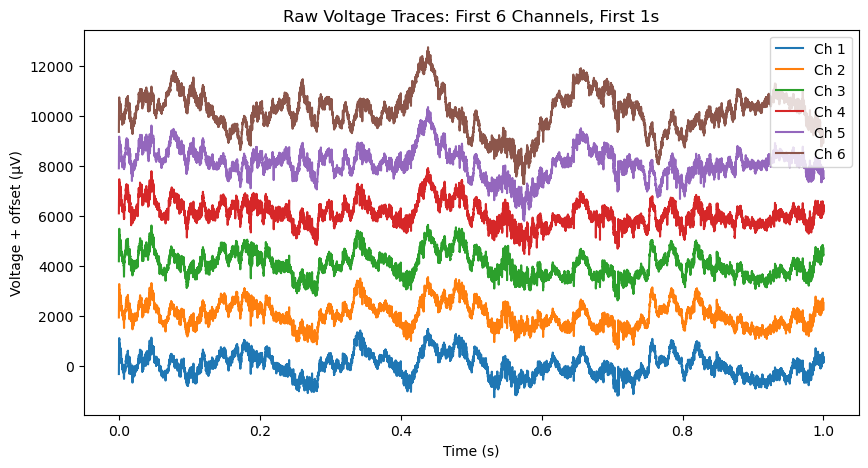

In [9]:
# Access and visualize a small segment of raw voltage data
ts = nwb.acquisition['time_series']
print(f"Raw data shape: {ts.data.shape} (samples, channels)")
print(f"Sampling rate: {ts.rate} Hz")
print(f"Units: {ts.unit}")

# Extract first 1 second (30,000 samples) from first 6 channels
segment = ts.data[:30000, :6]  # [time, channels]
time = np.arange(segment.shape[0]) / ts.rate  # Convert to seconds

# Plot raw traces with offset for visibility
plt.figure(figsize=(10,5))
for ch in range(6):
    plt.plot(time, segment[:, ch] + ch*2000, label=f'Ch {ch+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage + offset (μV)')
plt.title('Raw Voltage Traces: First 6 Channels, First 1s')
plt.legend(loc='upper right')
plt.show()

## Neural Unit Activity

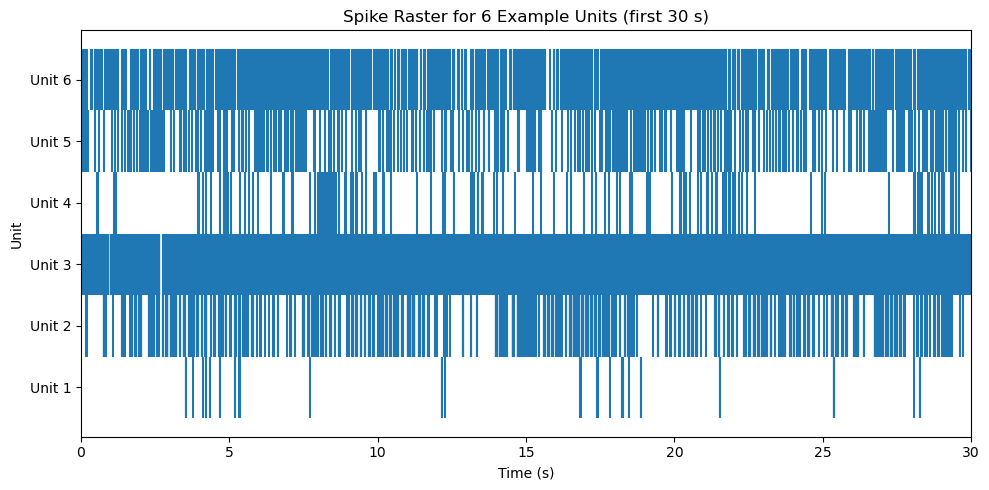

In [10]:
# Visualize spike raster for multiple units
plt.figure(figsize=(10,5))

# Plot spike rasters for first 6 units over first 30 seconds
for idx, (unit_id, row) in enumerate(units_df_full.head(6).iterrows()):
    spike_times = row['spike_times']
    # Filter spikes to first 30 seconds for visibility
    early_spikes = spike_times[spike_times <= 30]
    plt.vlines(early_spikes, idx+0.5, idx+1.5)

plt.yticks(np.arange(1, 7), [f'Unit {uid}' for uid in units_df_full.head(6).index])
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.title('Spike Raster for 6 Example Units (first 30 s)')
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

## Event-Aligned Analysis Example

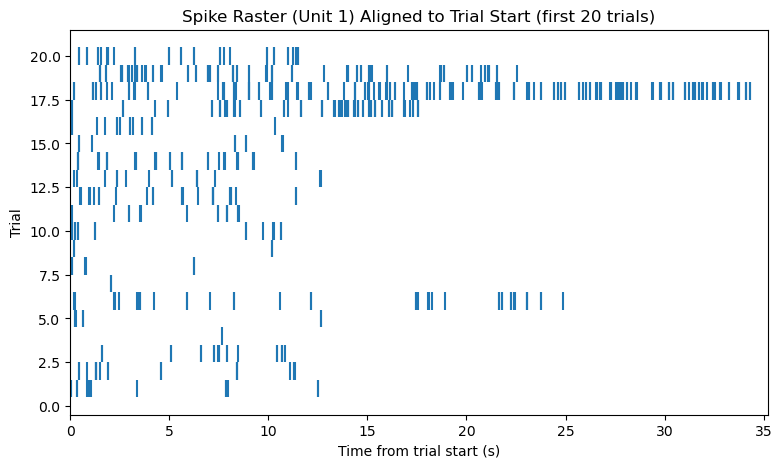

In [11]:
# Demonstrate trial-aligned spike analysis
# Select first unit for demonstration
unit_id, unit_row = next(units_df_full.iterrows())
spike_times = np.array(unit_row['spike_times'])

# Use first 20 trials for visualization
trial_starts = trials_df_full['start_time'].values[:20]
trial_durations = (trials_df_full['stop_time'] - trials_df_full['start_time']).values[:20]

# Align spikes to trial start times
peri_spike_times = []
for t_start, t_dur in zip(trial_starts, trial_durations):
    # Find spikes within this trial and convert to trial-relative time
    rel_spikes = spike_times[(spike_times >= t_start) & (spike_times <= t_start+t_dur)] - t_start
    peri_spike_times.append(rel_spikes)

# Plot trial-aligned raster
plt.figure(figsize=(9, 5))
for i, spikes in enumerate(peri_spike_times):
    plt.vlines(spikes, i+0.5, i+1.5)
plt.xlabel('Time from trial start (s)')
plt.ylabel('Trial')
plt.title(f'Spike Raster (Unit {unit_id}) Aligned to Trial Start (first 20 trials)')
plt.xlim(0, np.max(trial_durations))
plt.show()

## Getting Started with Your Analysis

This notebook demonstrates the core data structures and access patterns for this dandiset. The NWB files contain:

- **Raw electrophysiology**: High-resolution voltage traces from 256 channels
- **Spike-sorted units**: Identified neurons with precise spike timing
- **Behavioral trials**: Lap intervals in the virtual hallway task
- **Electrode metadata**: Spatial organization and recording parameters

**Next steps for analysis might include:**
- Computing peristimulus time histograms (PSTHs) around behavioral events
- Analyzing spike train correlations between units
- Investigating local field potential features
- Comparing neural activity patterns across experimental conditions

The code examples provided can be adapted for any of the three NWB files in this dandiset by changing the asset path in the loading step.